In [1]:
import numpy as np
from scipy.optimize import curve_fit
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib as mpl  
from utils_rename import moving_avg, remove_spike, plot_individual_phantom, plot_each_time_and_remove_spike, cal_R_square
# plot style format                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("seaborn-darkgrid")

# Setting Format

In [2]:
# setting format
date = '20230731'
phantom_measured_ID = ['2', '3', '4', '5']
SDS_idx = 4  # SDS=20 mm
SDS = 20 # [mm]

# Load measured phantom data

In [3]:
# get background Nx : time, Ny : intensity
background = pd.read_csv(os.path.join("dataset", date, "background.csv"))
used_wl = []
for k in background.keys().to_list()[1:]:
    used_wl += [float(k)]
background = background.to_numpy()[:,1:]
background = np.array(background, dtype=np.float64)

remove_spike_background = remove_spike(used_wl, background, normalStdTimes=10, showTargetSpec=False) # remove spike
time_mean_background = remove_spike_background.mean(axis=0) # mean of background signal

# get measured phantom data
phantom_data = [] # CHIK3456
for ID in phantom_measured_ID:
    # define plot savepath
    savepath = os.path.join(date, ID)
    os.makedirs(os.path.join("pic", savepath), exist_ok=True)
    
    # import measured data
    data = pd.read_csv(os.path.join('dataset', date, f'{ID}.csv'))
    data = data.to_numpy()[:,1:]
    data = np.array(data, dtype=np.float64)
    
    # remove spike
    remove_spike_data = remove_spike(used_wl, data, normalStdTimes=10, showTargetSpec=False) # remove spike
    time_mean_data = remove_spike_data.mean(0) # mean of measured signal
    
    # subtract background
    time_mean_data_sub_background = time_mean_data - time_mean_background
    
    # Do moving avg of spectrum
    moving_avg_I_data, moving_avg_wl_data = moving_avg(used_wl_bandwidth = 3,
                                                       used_wl = used_wl,
                                                       time_mean_arr = time_mean_data_sub_background)
    
    phantom_data.append(moving_avg_I_data)

target = [72, 576]
target = []
target = [119]
target = []
target = [582]


# Load simulated phantom data

In [4]:
# load used wavelength
with open(os.path.join("OPs_used", "wavelength.json"), "r") as f:
    wavelength = json.load(f)
    wavelength = wavelength['wavelength']

# binning meaurement wavelength 
binning_wavlength = 2 # nm
find_wl_idx = {}
for used_wl in wavelength:
    row = []
    for idx, test_wl in enumerate(moving_avg_wl_data):
        if abs(test_wl-used_wl) < binning_wavlength:
            row += [idx]          
    find_wl_idx[used_wl] = row
find_wl_idx

{700: [95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105],
 710: [122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132],
 717: [141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151],
 725: [163, 164, 165, 166, 167, 168, 169, 170, 171, 172],
 732: [181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191],
 740: [203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213],
 743: [211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221],
 748: [225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235],
 751: [233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243],
 753: [238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248],
 758: [252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262],
 763: [266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276],
 768: [279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289],
 780: [312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322],
 792: [346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356],
 798: [362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372],
 8

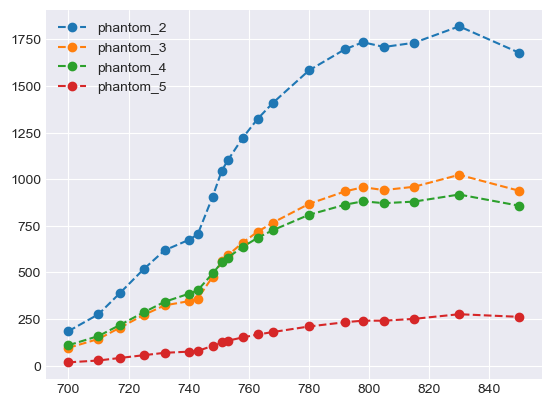

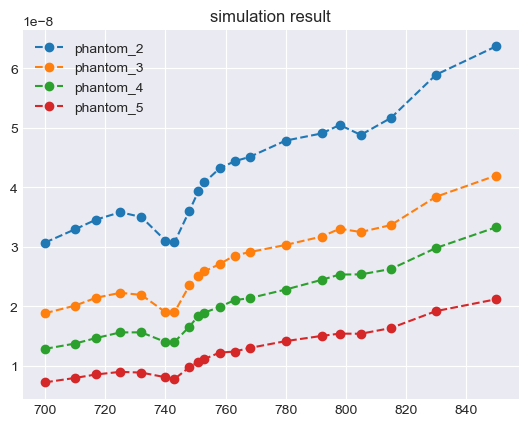

In [5]:
## Get the same simulated wavelength point from measured phantom
measured_phantom_data = []
used_phantom_data = phantom_data
for idx, data in enumerate(used_phantom_data):
    avg_wl_as_data = []
    for k in find_wl_idx.keys():
        average_idx = find_wl_idx[k]
        avg_wl_as_data += [data[average_idx].mean()]
    measured_phantom_data.append(avg_wl_as_data)
    plt.plot(wavelength, avg_wl_as_data, 'o--', label=f'phantom_{phantom_measured_ID[idx]}')
plt.legend()
plt.savefig(os.path.join("pic", date, "measured_phantom_adjust_wl.png"), dpi=300, format='png', bbox_inches='tight')
plt.show()
measured_phantom_data = np.array(measured_phantom_data)


## Get simulated phantom data
sim_phantom_data = []
for c in phantom_measured_ID:
    data = np.load(os.path.join("dataset", "phantom_simulated", f'{c}.npy'))
    sim_phantom_data.append(data[:,SDS_idx].tolist())
    plt.plot(wavelength, data[:,SDS_idx], 'o--',label=f'phantom_{c}')
plt.title("simulation result")
plt.legend()
plt.savefig(os.path.join("pic", date, "simulated_phantom_adjust_wl.png"), dpi=300, format='png', bbox_inches='tight')
plt.show()
sim_phantom_data = np.array(sim_phantom_data)


In [6]:
def califunc(x, a):
    y = a*x
    return y

from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=False)
model_intp = LinearRegression(fit_intercept=True)

# Fit measured phantom and simulated phantom

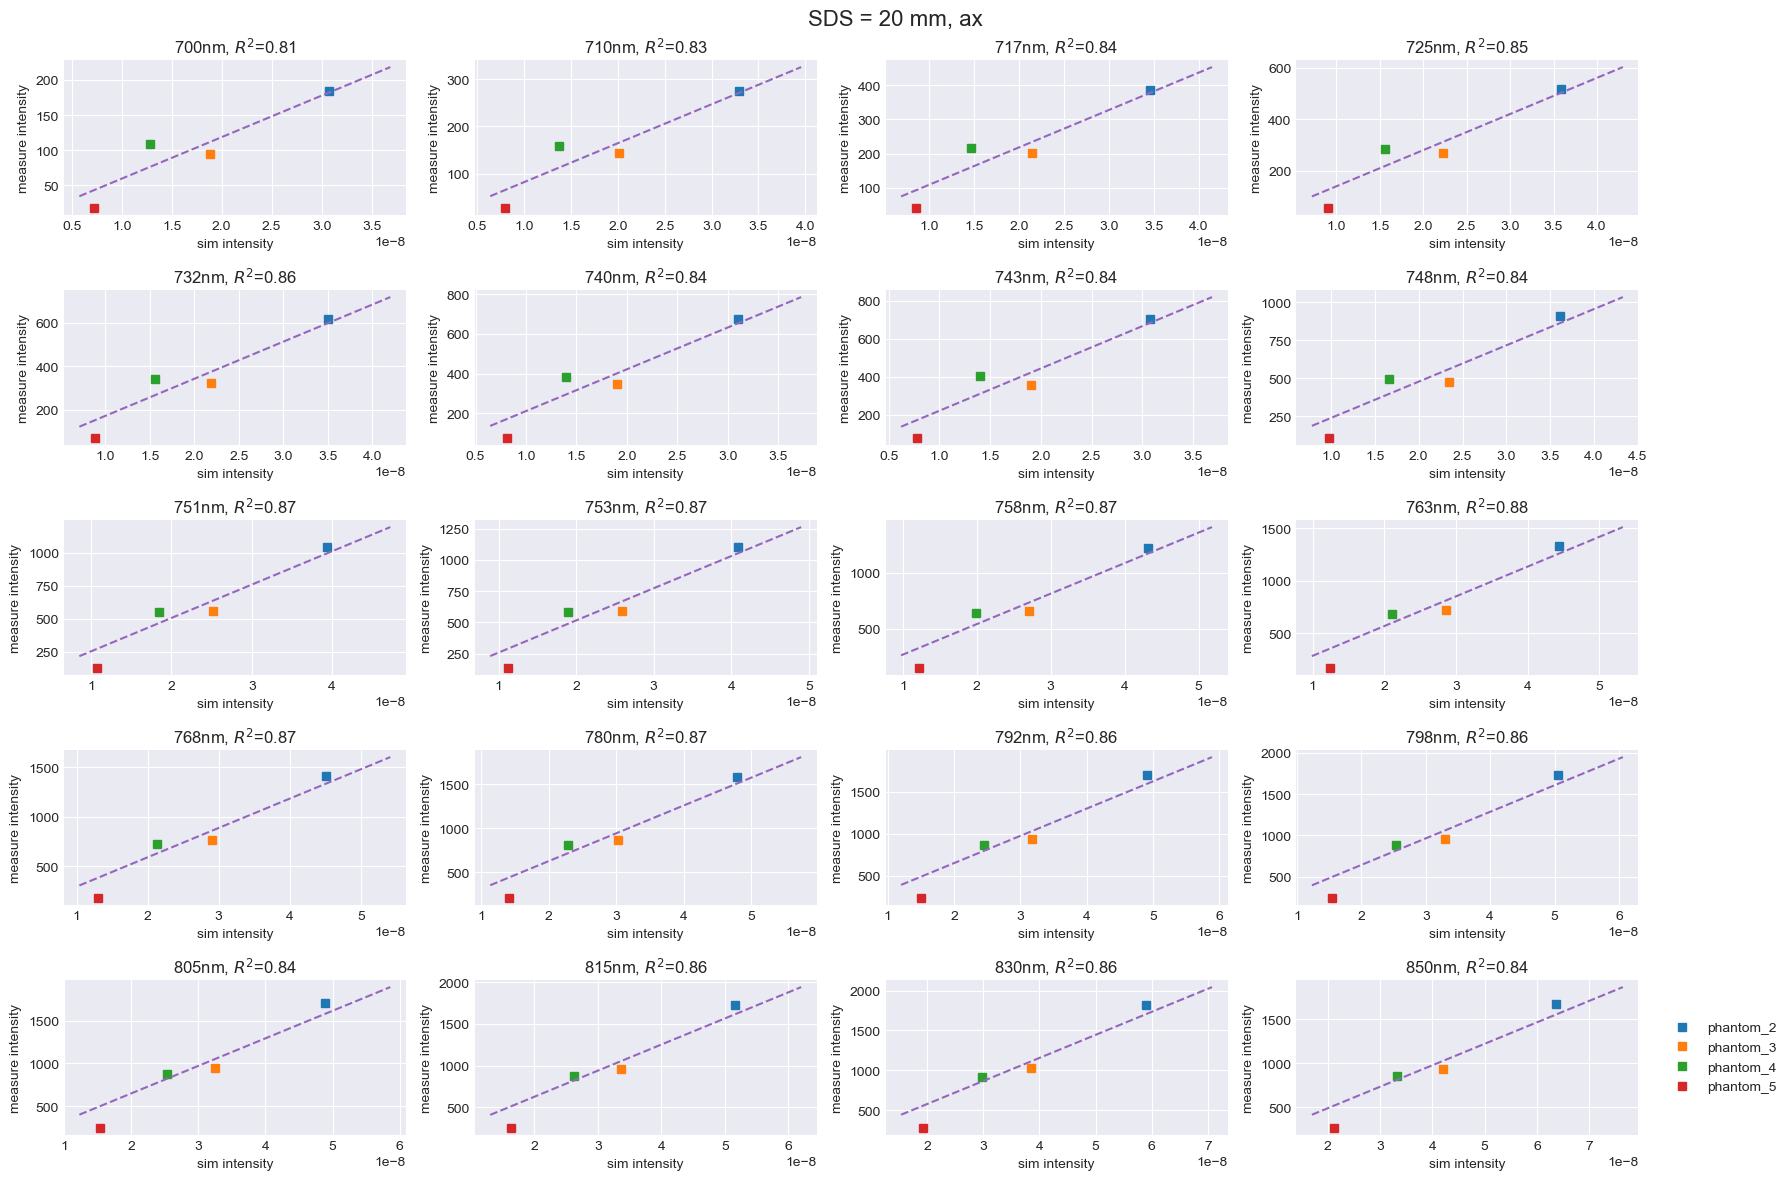

In [11]:
fig = plt.figure(figsize=(18,12))
fig.suptitle(f"SDS = {SDS} mm, ax", fontsize=16)
count = 1
result = {}
for idx, used_wl in enumerate(wavelength):
    ## fit measured phantom and simulated phantom
    # popt, pcov = curve_fit(califunc, sim_phantom_data[:, idx], measured_phantom_data[:, idx])
    model.fit(sim_phantom_data[:, idx][:, None], measured_phantom_data[:, idx])
    model_intp.fit(sim_phantom_data[:, idx][:, None], measured_phantom_data[:, idx])
    # print(f"popt: {popt}")
    # z = np.polyfit(sim_phantom_data[:,idx], measured_phantom_data[:, idx], 1)
    plotx = np.linspace(sim_phantom_data[-1, idx]*0.8,  sim_phantom_data[0, idx]*1.2,100)
    # ploty = plotx*z[0] + z[1]
    # ploty = califunc(plotx, *popt)
    ploty = plotx * model.coef_[0] + model.intercept_
    ploty_intp = plotx * model_intp.coef_[0] + model_intp.intercept_
    # calibrate_data = sim_phantom_data[:, idx]*z[0] + z[1]
    # calibrate_data = califunc(sim_phantom_data[:, idx], *popt)
    calibrate_data = sim_phantom_data[:, idx] * model.coef_[0] + model.intercept_
    calibrate_data_intp = sim_phantom_data[:, idx] * model_intp.coef_[0] + model_intp.intercept_
    R_square = cal_R_square(calibrate_data, measured_phantom_data[:,idx]) # cal R square
    R_square_intp = cal_R_square(calibrate_data_intp, measured_phantom_data[:,idx]) # cal R square with intercept
    
    result[used_wl] = [model.coef_[0], model.intercept_, R_square, R_square_intp]
    
    ## plot result
    ax = plt.subplot(5,4, count)
    ax.set_title(f"@wavelength={used_wl} nm")
    ax.set_title(f'{used_wl}nm, $R^{2}$={R_square:.2f}')
    for ID_idx, ID in enumerate(phantom_measured_ID):
        ax.plot(sim_phantom_data[ID_idx, idx], measured_phantom_data[ID_idx,idx], 's', label=f'phantom_{ID}')
    ax.plot(plotx, ploty, '--')
    ax.set_xlabel("sim intensity")
    ax.set_ylabel("measure intensity")
    count += 1
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
                    fancybox=True, shadow=True)
plt.tight_layout()
plt.savefig(os.path.join('pic', savepath, "all.png"), dpi=300, format='png', bbox_inches='tight')
plt.show()

# Save fitting result as csv

In [8]:
# result = {}
# for idx, used_wl in enumerate(wavelength):
#     model.fit(sim_phantom_data[:, idx][:, None], measured_phantom_data[:, idx])
#     # z = np.polyfit(measured_phantom_data[:, idx], sim_phantom_data[:,idx], 1)
#     # result[used_wl] = z
#     result[used_wl] = [model.coef_[0], model.intercept_]
result = pd.DataFrame(result)
os.makedirs(os.path.join("result", date) , exist_ok=True)
result.to_csv(os.path.join("result", date, "calibrate_result.csv"), index=False)

In [11]:
measured_phantom_data.shape

(4, 20)

# Plot spectrum and process signal of measured phantom

ValueError: x and y must have same first dimension, but have shapes (1,) and (1024,)

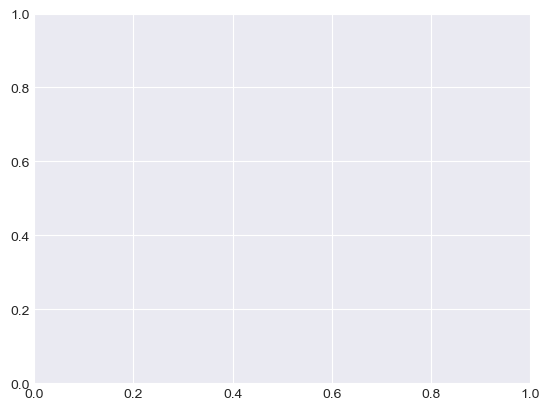

In [8]:
for ID in phantom_measured_ID:
    # define plot savepath
    savepath = os.path.join(date, ID)
    os.makedirs(os.path.join("pic", savepath), exist_ok=True)
    
    # plot
    plot_individual_phantom(used_wl, 
                            time_mean_np_arr = time_mean_data, 
                            time_mean_np_arr_remove_bg = time_mean_data_sub_background,
                            moving_avg_I = moving_avg_I_data, 
                            moving_avg_wl = moving_avg_wl_data, 
                            name = ID,
                            savepath = savepath)

## Plot all measured phantom together

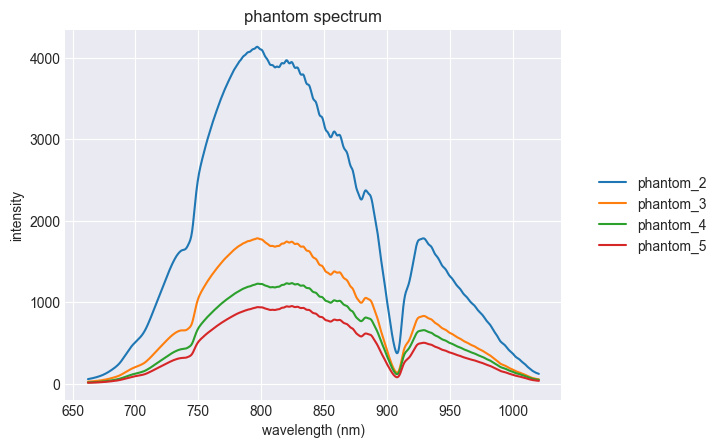

In [28]:
for idx, data in enumerate(phantom_data):
    plt.plot(moving_avg_wl_data, data, label=f'phantom_{phantom_measured_ID[idx]}')
plt.title('phantom spectrum')
plt.xlabel('wavelength (nm)')
plt.ylabel('intensity')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
                fancybox=True, shadow=True)
plt.savefig(os.path.join("pic", date, "2345_phantom_result.png"), dpi=300, format='png', bbox_inches='tight')
plt.show()